# Train a convnet to recognize shoe brands

**Algorithm:**
1. Visualize images
2. Set and visualize image augmentation
3. Configure convolutional network architecture
4. Train the net
5. Visualize training progress
5. Visualize predictions
6. Save model

Note: test directory is used as validation 

In [4]:
from __future__ import print_function, division
import os
from tqdm import tqdm
import shutil
import numpy as np
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
%matplotlib inline


In [5]:
TRAIN_DIR = './Train/'
TEST_DIR = './Test/'

TRAIN_FILE = './train_df.csv'
TEST_FILE = './test_df.csv'

### Data prep

##### Get class labels

In [6]:
classes = os.listdir(TRAIN_DIR)

len(classes)

14

##### Initialize dataset class

In [7]:
class ShoeBrandDataset(Dataset):
    def __init__(self, root_dir, filepath, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            filepath (string): Path to a file with class labels and image paths
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.class_files = pd.read_csv(filepath)
        self.transform = transform
        self.lab2idx = {lab:idx for idx,lab in enumerate(os.listdir(root_dir))}
        self.idx2lab = {idx:lab for lab,idx in self.lab2idx.items()}

    def __len__(self):
        return len(self.class_files)

    def __getitem__(self, idx):
        label,filepath = self.class_files.iloc[idx]
        image = io.imread(filepath)
        sample = {'image': image, 'label': self.lab2idx[label]}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [8]:
shoe_dataset = ShoeBrandDataset(filepath=TRAIN_FILE,
                                root_dir=TRAIN_DIR)

##### Visualize random images 
output image sizes and labels

1144 (2000, 2000, 3)
214 (1000, 1000, 3)
663 (899, 936, 3)
5677 (552, 864, 3)
2641 (500, 750, 3)
2173 (625, 895, 3)


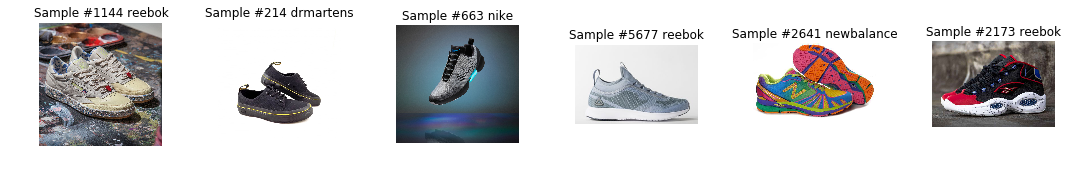

In [9]:
N_SHOW = 6

fig = plt.figure(figsize=(15,4))

for i in range(N_SHOW):
    index = np.random.randint(0, len(shoe_dataset), size=1)[0]
    sample = shoe_dataset[index]

    print(index, sample['image'].shape)

    ax = plt.subplot(1, 6, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} {}'.format(index, shoe_dataset.idx2lab[sample['label']]))
    plt.imshow(sample['image'])
    ax.axis('off')
    
plt.show()

##### Add image augmentation
- normalization to be centered around 0.4-0.5 across all channels and with ~0.22 standard deviation
- resizing to have width and height at 256 
- random cropping to get 244x244x3 images

In [10]:
norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
crop = transforms.RandomCrop(224)
resize = transforms.Resize(256)

tsfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(30),
    resize,
    crop,
    transforms.ToTensor(),
    norm,
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


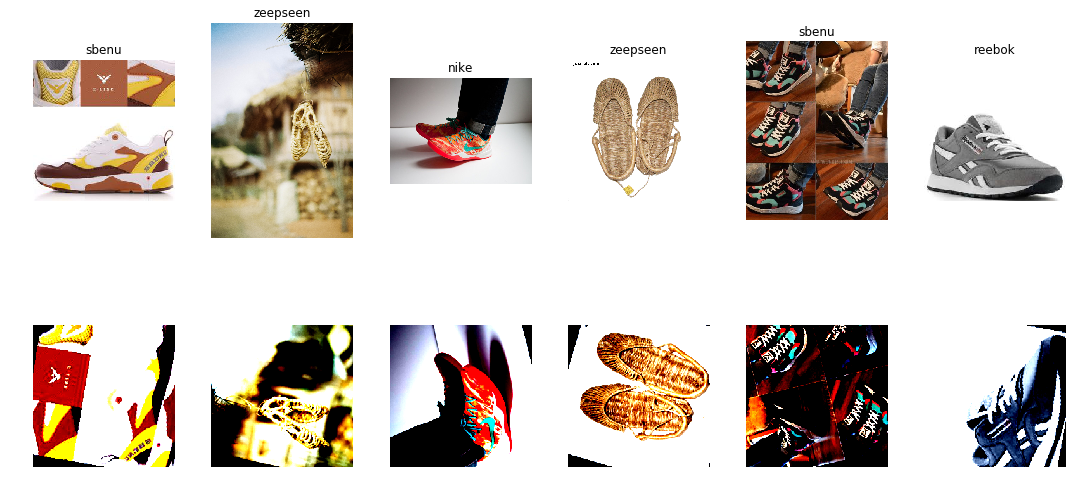

In [11]:
N_SHOW = 6

fig = plt.figure(figsize=(15,8))

for i in range(N_SHOW):
    index = np.random.randint(0, len(shoe_dataset), size=1)[0]
    sample = shoe_dataset[index]
    transformed = tsfm(sample['image'])
    transformed = np.array(transformed).transpose(2,1,0)

    ax = plt.subplot(2, N_SHOW, i + 1)
    ax.set_title(shoe_dataset.idx2lab[sample['label']])
    ax.imshow(sample['image'])
    ax.axis('off')
    
    ax = plt.subplot(2, N_SHOW, i + 1 + N_SHOW)
    ax.imshow(transformed)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

### Define the conv net

##### Imports and variables definition

In [19]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import copy

In [14]:
BATCH_SIZE = 64

N_CLASSES = len(classes)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


##### Define train and validation data loaders

In [31]:
train_dataset = ShoeBrandDataset(filepath=TRAIN_FILE,
                                   root_dir=TRAIN_DIR,
                                   transform=tsfm,
                                   )

test_dataset = ShoeBrandDataset(filepath=TEST_FILE,
                               root_dir=TEST_DIR,
                               transform=tsfm,
                                )

In [32]:
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,)

testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, )


In [33]:
dataloaders = {
    'train': trainloader,
    'val': testloader,
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(test_dataset),
}

##### Model architecture

Try different pretrained models

In [20]:
# model = models.resnet50(pretrained=True)
# model = models.inception.inception_v3(pretrained=True)
# fc = model.fc.in_features
# model.fc = nn.Linear(fc, N_CLASSES, )

model = models.densenet121(pretrained=True,)
fc = model.classifier.in_features
model.classifier = nn.Linear(fc, N_CLASSES)

net = model
net.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

##### Model training configs

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, history=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    if history:
        epoch_start = max(history['epoch'])
    else:
        epoch_start = 0
        history = {'epoch': [],
                   'loss': [],
                   'score': [],
                   'val_loss': [],
                   'val_score': [],
                   }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs = data['image'].to(device)
                labels = data['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                history['epoch'].append(epoch + epoch_start)
                history['loss'].append(epoch_loss)
                history['score'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_score'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,history

### Train and evaluate the model

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.RMSprop(net.parameters(), lr=0.001,)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [35]:
N_EPOCH = 10

In [36]:
   
model_ft,history = train_model(net,
                               criterion,
                               optimizer,
                               exp_lr_scheduler,
                               num_epochs=N_EPOCH,
                               history=None)

Epoch 0/9
----------
train Loss: 1.3187 Acc: 0.5776
val Loss: 1.4942 Acc: 0.6005

Epoch 1/9
----------
train Loss: 0.8859 Acc: 0.7233
val Loss: 0.9452 Acc: 0.7046

Epoch 2/9
----------
train Loss: 0.7159 Acc: 0.7711
val Loss: 0.9157 Acc: 0.7312

Epoch 3/9
----------
train Loss: 0.5935 Acc: 0.8111
val Loss: 0.9406 Acc: 0.7409

Epoch 4/9
----------
train Loss: 0.5488 Acc: 0.8247
val Loss: 0.9375 Acc: 0.7240

Epoch 5/9
----------
train Loss: 0.5029 Acc: 0.8408
val Loss: 0.9168 Acc: 0.7482

Epoch 6/9
----------
train Loss: 0.3844 Acc: 0.8745
val Loss: 0.9876 Acc: 0.7458

Epoch 7/9
----------
train Loss: 0.2598 Acc: 0.9170
val Loss: 0.5608 Acc: 0.8547

Epoch 8/9
----------
train Loss: 0.1731 Acc: 0.9495
val Loss: 0.5745 Acc: 0.8378

Epoch 9/9
----------
train Loss: 0.1429 Acc: 0.9577
val Loss: 0.5044 Acc: 0.8571

Training complete in 54m 44s
Best val Acc: 0.857143


##### Show learning curves

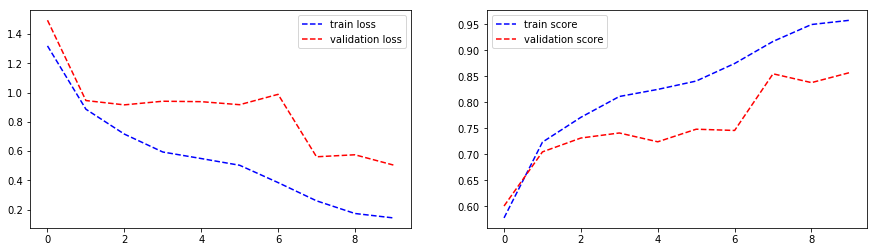

In [37]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(history['epoch'], history['loss'], 'b--', label='train loss')
plt.plot(history['epoch'], history['val_loss'], 'r--', label='validation loss')
plt.legend()
plt.subplot(122)
plt.plot(history['epoch'], history['score'], 'b--', label='train score')
plt.plot(history['epoch'], history['val_score'], 'r--', label='validation score')
plt.legend()
plt.show()

##### Evaluate accuracy

- total val accuracy
- show correct and wrong (randomly) predictions
- get accuracy by brand

In [44]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs = Variable(data['image'].to(device))
        labels = Variable(data['label'].to(device))
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc_perc = int(100 * correct / total)
print('Accuracy of the network on the %d test images: %d %%' % (
    total, acc_perc))

Accuracy of the network on the 413 test images: 86 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

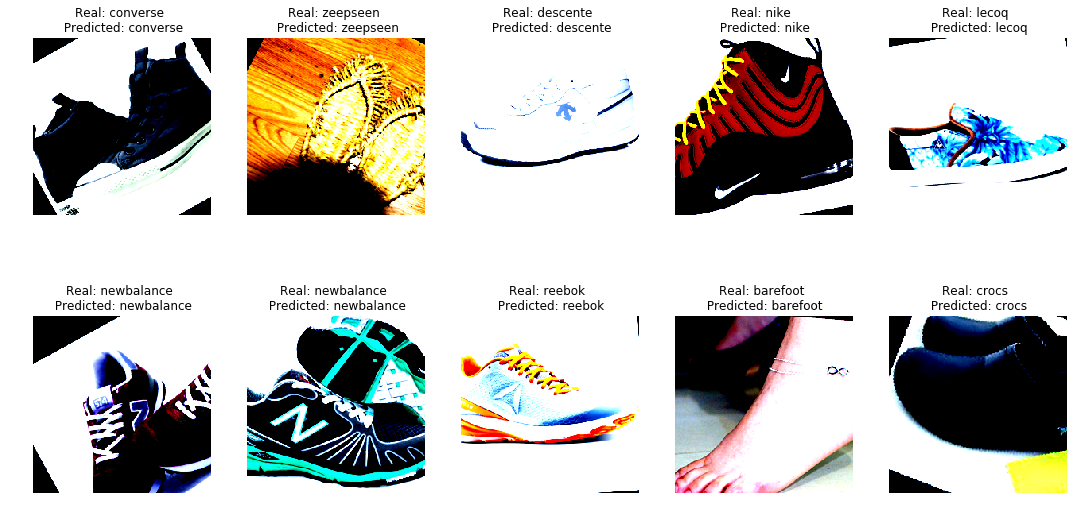

In [39]:
N_SHOW = 10

plt.figure(figsize=(15,8))
for i in range(N_SHOW):
    plt.subplot(2,5,i+1)
    img = np.moveaxis(np.array(inputs[i]), 0, 2) #reshape(224,224,3)
    plt.imshow(img)
    ttl = ['Real:', classes[labels[i]], '\n', 'Predicted:', classes[predicted[i].item()]]
    plt.title(" ".join(ttl))
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [40]:
class_correct = list(0. for i in range(N_CLASSES))
class_total = list(0. for i in range(N_CLASSES))
with torch.no_grad():
    for data in testloader:
        inputs = Variable(data['image'].to(device))
        labels = Variable(data['label'].to(device))
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in labels:
            label = labels[i]
            class_correct[i] += c[i].item()
            class_total[i] += 1


for i in range(N_CLASSES):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of lecoq : 85 %
Accuracy of crocs : 100 %
Accuracy of sbenu : 100 %
Accuracy of descente : 100 %
Accuracy of zeepseen : 91 %
Accuracy of converse : 90 %
Accuracy of barefoot : 100 %
Accuracy of newbalance : 100 %
Accuracy of adidas : 44 %
Accuracy of  puma : 92 %
Accuracy of  nike : 100 %
Accuracy of drmartens : 84 %
Accuracy of reebok : 100 %
Accuracy of  vans : 100 %


##### Send notification to telegram after training

In [41]:
!python3 /data/home/akbds/.local/lib/python3.5/site-packages/telegram_send.py 'Done training the model'

##### Save model for future use

In [46]:
SAVE_CHECKPOINT = 'densenet121_checkpoint.pt'

In [48]:
torch.save({
            'epoch': max(history['epoch']),
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': acc_perc, 
            }, SAVE_CHECKPOINT)